# Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

# Загрузка, анализ и подготовка данных

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor
from lightgbm import plot_importance

from catboost import CatBoostRegressor

from tensorflow import keras
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_arc_new = pd.read_csv('/datasets/data_arc_new.csv', parse_dates=['Начало нагрева дугой','Конец нагрева дугой'])
data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv', parse_dates=['Bulk 1','Bulk 2','Bulk 3','Bulk 4','Bulk 5','Bulk 6','Bulk 7','Bulk 8','Bulk 9','Bulk 10','Bulk 11','Bulk 12','Bulk 13','Bulk 14','Bulk 15'])
data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
data_temp_new = pd.read_csv('/datasets/data_temp_new.csv', parse_dates=['Время замера'])
data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv', parse_dates=['Wire 1','Wire 2','Wire 3','Wire 4','Wire 5','Wire 6','Wire 7','Wire 8','Wire 9'])

In [3]:
data_arc_new.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587            

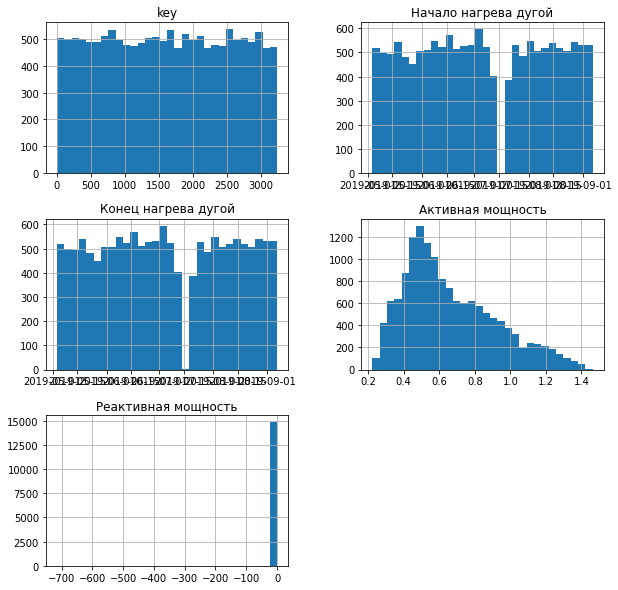

In [4]:
print(data_arc_new.info())
print(data_arc_new.describe())
data_arc_new.hist(bins=30,figsize=(10,10));
print('----------------------')
print('Количество уникальных ковшей ',len(data_arc_new['key'].unique()))
#вектор уникальных ковшей
key_unique = data_arc_new['key'].unique()

In [5]:
data_arc_new[data_arc_new['Реактивная мощность']<0]
#OUTLIER

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [6]:
data_bulk_new.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   

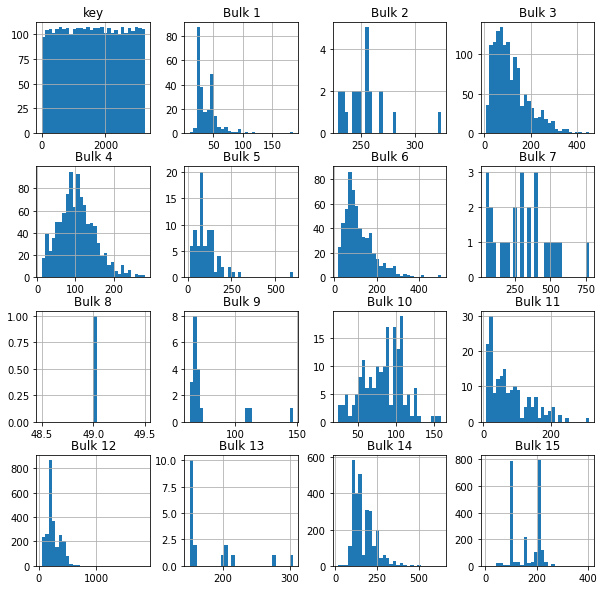

In [7]:
print(data_bulk_new.info())
print(data_bulk_new.describe())
data_bulk_new.hist(bins=30,figsize=(10,10));
print('----------------------')
print('Количество уникальных ковшей ',len(data_bulk_new['key'].unique()))
print()

In [8]:
data_bulk_time_new.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaT,NaT,NaT,2019-05-03 13:57:27,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:48:52,NaT,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaT,NaT,NaT,2019-05-03 14:18:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:41:26,NaT,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaT,NaT,NaT,2019-05-03 15:17:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 15:17:58,NaT,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaT,NaT,NaT,2019-05-03 16:03:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:03:08,NaT,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:38:11,NaT,2019-05-03 16:34:24,2019-05-03 16:29:56


In [9]:
print(data_bulk_time_new.info())
print(data_bulk_time_new.describe())
print('----------------------')
print('Количество уникальных ковшей ',len(data_bulk_time_new['key'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB
None
               key

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
----------------------
Количество уникальных ковшей  3239


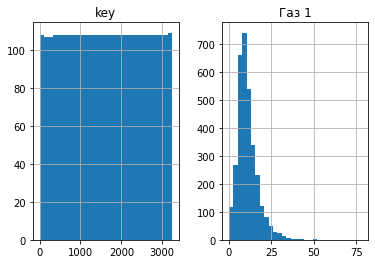

In [10]:
display(data_gas_new.head(10))
data_gas_new.hist(bins=30);
print(data_gas_new.info())
print('----------------------')
print('Количество уникальных ковшей ',len(data_gas_new['key'].unique()))

In [11]:
data_temp_new.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB
None
----------------------
Количество уникальных ковшей  3216


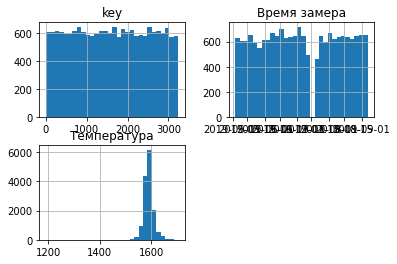

In [12]:
print(data_temp_new.info())
data_temp_new.hist(bins=30);
print('----------------------')
print('Количество уникальных ковшей ',len(data_temp_new['key'].unique()))
#есть времена замера, но нет температуры, жаль, и разница очень существенная - почему так?
#ниже проверим + уникальных ковшей 3216, а не 3214

In [13]:
data_wire_new.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15

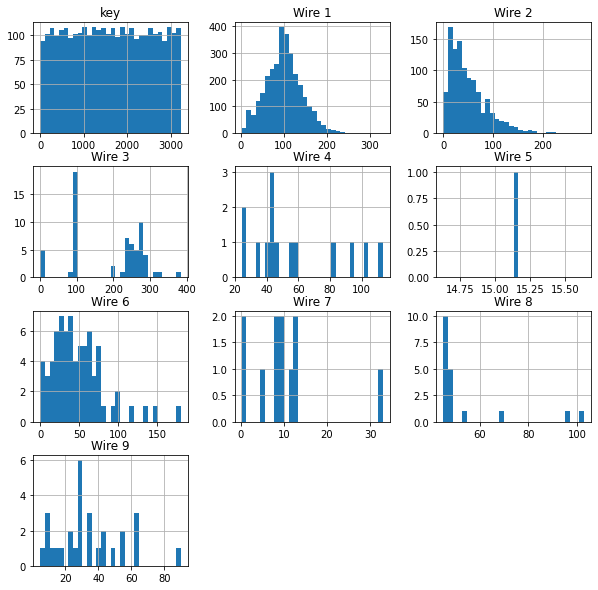

In [14]:
print(data_wire_new.info())
print(data_wire_new.describe())
data_wire_new.hist(bins=30,figsize=(10,10));
print('----------------------')
print('Количество уникальных ковшей ',len(data_wire_new['key'].unique()))

In [15]:
data_wire_time_new.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT
6,7,2019-05-03 14:18:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,8,2019-05-03 15:01:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [16]:
print(data_wire_time_new.info())
print(data_wire_time_new.describe())
print('----------------------')
print('Количество уникальных ковшей ',len(data_wire_time_new['key'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB
None
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000
----------------------
Количество уникальных ковшей  3081


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Проверки на корректность:
количество ковшей должно совпадать и сами ковши должны совпадать

Для одного и того же key тайминг должен быть ненарушен

количество прормежутков между временами должно быть равно количеству действий (bulk + wire)

<b>Выводы: </b> Данные в целом хорошего качества, практически без выбросов, достаточно понятно офрмлены и не прортиворечат друг другу. Далее проверим данные на логичность/полноту, далее посмотрим наличие зависимостей внутри данных для корректного выбора признаков модели.  

## Проверка на ошибки в данных

In [17]:
temp_check = data_temp_new.groupby(by='key').count()
display(temp_check)
key_wrong = temp_check.loc[temp_check['Время замера']!=temp_check['Температура']].index
#ковши для которых время замера и температура не совпадают

,Время замера,Температура
key,,
1,6,6
2,5,5
3,6,6
4,5,5
5,5,5
...,...,...
3237,6,1
3238,4,1
3239,9,1


In [18]:
# найдем ковши, для которых есть информация во всех таблицах
key_common = range(1,4000)

for k in (data_arc_new['key'].unique(),
                           data_bulk_new['key'].unique(),
                           data_bulk_time_new['key'].unique(),
                           data_gas_new['key'].unique(),
                           data_temp_new['key'].unique(),
                           data_wire_new['key'].unique(),
                           data_wire_time_new['key'].unique()):
                        key_common = np.intersect1d(key_common,k)
        
key_common = key_common[~np.isin(key_common,key_wrong)&(key_common!=2116)] #2116 отриц реактив мощность дyги
len(key_common)        

2328

In [19]:
data_arc_new = data_arc_new.loc[data_arc_new['key'].isin(key_common)] 
data_bulk_new = data_bulk_new.loc[data_bulk_new['key'].isin(key_common)]
data_bulk_time_new = data_bulk_time_new.loc[data_bulk_time_new['key'].isin(key_common)]
data_gas_new = data_gas_new.loc[data_gas_new['key'].isin(key_common)]
data_temp_new = data_temp_new.loc[data_temp_new['key'].isin(key_common)]
data_wire_new = data_wire_new.loc[data_wire_new['key'].isin(key_common)]
data_wire_time_new = data_wire_time_new.loc[data_wire_time_new['key'].isin(key_common)]

In [20]:
# #прорверка на количество действий и замеров между ними
# diff = (data_temp_new.groupby(by='key').count()['Температура']-
# data_wire_new.groupby('key')[['Wire 1','Wire 2','Wire 3','Wire 4','Wire 5','Wire 6','Wire 7','Wire 8','Wire 9']].count().sum(axis=1)-
# data_bulk_new.groupby('key').count().sum(axis=1)
#  -1)
# key_common = key_common[diff!=0] #исключаем ковши где вроде как измеряли, а температуру не написали

In [21]:
#Данные для тех ковшей, в которых нет ошибок
data_arc_new = data_arc_new.loc[data_arc_new['key'].isin(key_common)] 
data_bulk_new = data_bulk_new.loc[data_bulk_new['key'].isin(key_common)]
data_bulk_time_new = data_bulk_time_new.loc[data_bulk_time_new['key'].isin(key_common)]
data_gas_new = data_gas_new.loc[data_gas_new['key'].isin(key_common)]
data_temp_new = data_temp_new.loc[data_temp_new['key'].isin(key_common)]
data_wire_new = data_wire_new.loc[data_wire_new['key'].isin(key_common)]
data_wire_time_new = data_wire_time_new.loc[data_wire_time_new['key'].isin(key_common)]

## Формируем признаки и таргет


    В качестве целевой функции примем последнюю измеренную температуру для каждого ковша.

    Признаками будут: 
    - Начальная температура
    - Суммарное количество поданной активной и реактивной энергии
    - Количество каждой поданной сухой смеси
    - Количество каждой поданной проволоки
    - Информацию о продувке газом

In [22]:
#берем последнюю температуру в измерениях дл каждого, это будет target
temp_target = data_temp_new.groupby('key')['Температура'].last()

In [23]:
temp_target.shape

(2328,)

In [24]:
#сколько подавалось энергии на дугу

data_arc_new['act_energy'] = (data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']).astype(int)/1e10 * data_arc_new['Активная мощность']
data_arc_new['react_energy'] = (data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']).astype(int)/1e10 * data_arc_new['Реактивная мощность']

In [25]:
data_arc_new

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,act_energy,react_energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,6.956964,4.816568
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,14.164673,8.832603
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,9.981384,7.403912
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,18.925104,13.869233
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,12.833568,9.526627
...,...,...,...,...,...,...,...
11444,2498,2019-08-10 13:20:18,2019-08-10 13:20:59,0.508786,0.363916,2.086023,1.492056
11445,2499,2019-08-10 13:33:31,2019-08-10 13:38:43,0.700677,0.534767,21.861122,16.684730
11446,2499,2019-08-10 13:41:44,2019-08-10 13:45:09,0.333776,0.269695,6.842408,5.528748
11447,2499,2019-08-10 13:46:38,2019-08-10 13:51:33,0.406252,0.263303,11.984434,7.767438


In [26]:
act_en = data_arc_new[['key','Начало нагрева дугой','act_energy']]
act_en = act_en.set_index('act'+act_en.index.astype(str))
react_en = data_arc_new[['key','Конец нагрева дугой','react_energy']]
react_en = react_en.set_index('react'+react_en.index.astype(str))

In [27]:
act_en

,key,Начало нагрева дугой,act_energy
act0,1,2019-05-03 11:02:14,6.956964
act1,1,2019-05-03 11:07:28,14.164673
act2,1,2019-05-03 11:11:44,9.981384
act3,1,2019-05-03 11:18:14,18.925104
act4,1,2019-05-03 11:26:09,12.833568
...,...,...,...
act11444,2498,2019-08-10 13:20:18,2.086023
act11445,2499,2019-08-10 13:33:31,21.861122
act11446,2499,2019-08-10 13:41:44,6.842408
act11447,2499,2019-08-10 13:46:38,11.984434


In [30]:
bulk = data_bulk_new.fillna(0).set_index('key')
wire = data_wire_new.fillna(0).set_index('key')
act_en_cum = act_en.groupby('key').sum()['act_energy']
react_en_cum = react_en.groupby('key').sum()['react_energy']
temp_init = data_temp_new.groupby('key').first()['Температура']
temp_fin = data_temp_new.groupby('key').first()['Температура']

In [31]:
temp_init.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            2489, 2490, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499],
           dtype='int64', name='key', length=2328)

In [32]:
features = pd.concat([bulk,wire,pd.concat([act_en_cum,react_en_cum,temp_init],axis=1)],axis=1)

In [33]:
features

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,act_energy,react_energy,Температура
key,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.861693,44.448944,1571.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.528180,27.469000,1581.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.177462,42.803892,1596.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.371027,41.394198,1601.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.218048,30.307092,1576.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.153932,39.228067,1570.0
2496,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.522247,45.698724,1554.0
2497,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.032667,46.286278,1571.0


<b>Проверка мультиколлинеарности в данных </b>

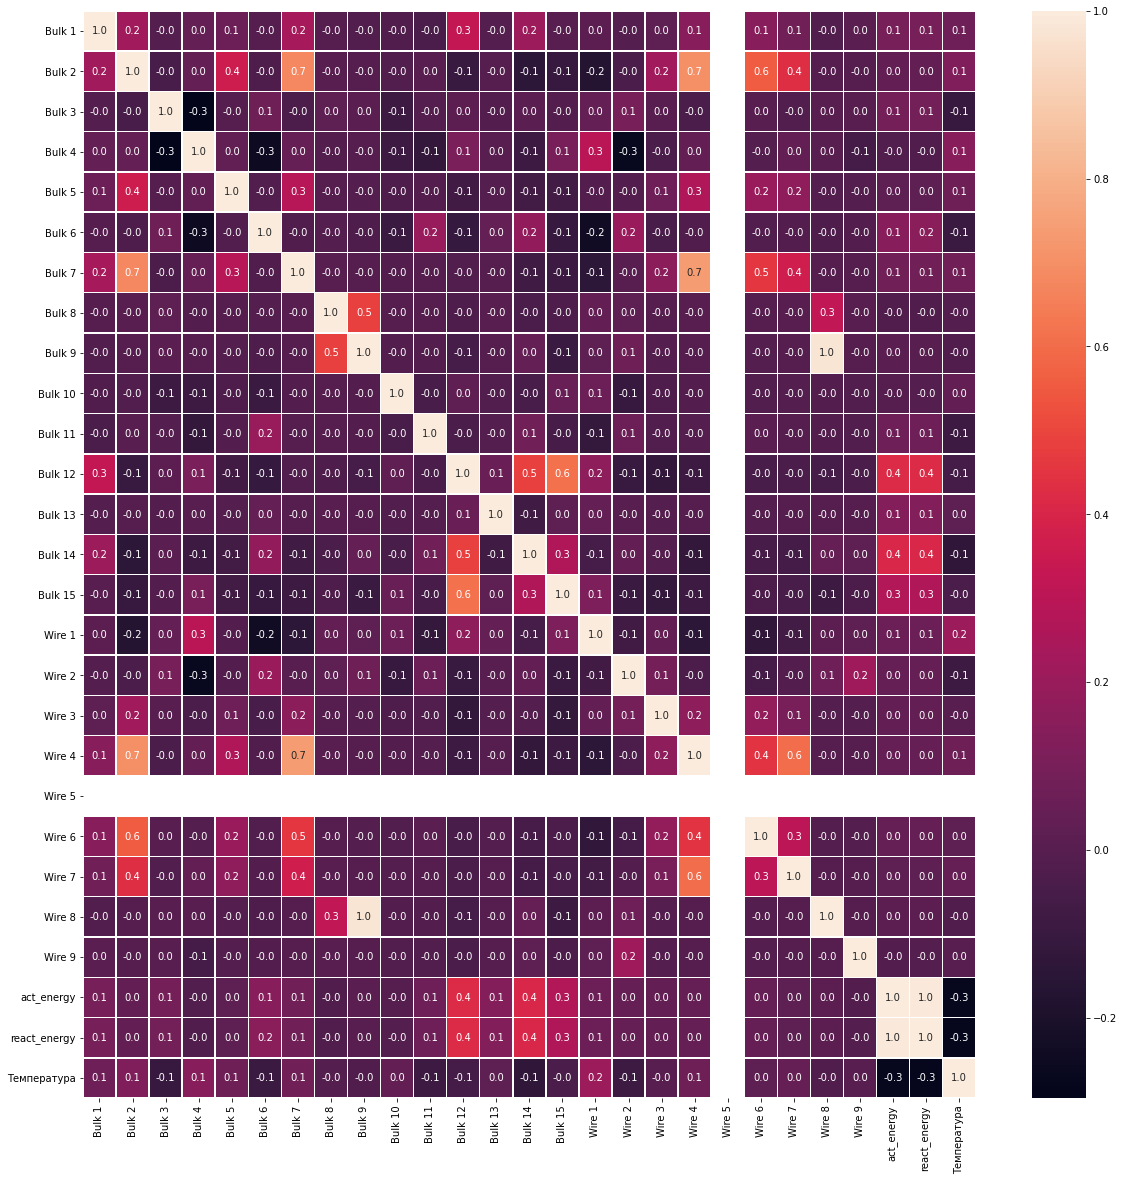

In [34]:
#Построим тепловую карту корреляции в данных
#В целом, коррелированных столбцов не так много, но есть корреляция 0.7
# Bulk 7 - Bulk 2
# Wire 4 - Bulk 2
#Корреляция почти 1
#Wire 8 - Bulk 9
# Active energy - Reactive energy : можно оставить для анализа только один признак из этой пары
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(features.corr(), annot=True, fmt="0.1f", linewidths=.5, ax=ax);

In [35]:
features = features.drop(['Wire 5','Wire 8','react_energy'],axis=1)
display(features)

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 9,act_energy,Температура
key,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,62.861693,1571.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,39.528180,1581.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,58.177462,1596.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,54.371027,1601.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,41.218048,1576.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,57.153932,1570.0
2496,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,67.522247,1554.0
2497,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,68.032667,1571.0


##  Моделирование

In [36]:
target = temp_target

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=220523)

In [37]:
#rescale features
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)

In [38]:
target.rename('Temperature_finish')


key
1       1613.0
2       1602.0
3       1599.0
4       1625.0
5       1602.0
         ...  
2495    1591.0
2496    1591.0
2497    1589.0
2498    1594.0
2499    1603.0
Name: Temperature_finish, Length: 2328, dtype: float64

In [39]:
features.columns

Index(['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7',
       'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13',
       'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6',
       'Wire 7', 'Wire 9', 'act_energy', 'Температура'],
      dtype='object')

### Линейная регрессия

In [40]:
model_linear = LinearRegression()
results_linear = cross_validate(model_linear, features_train, target_train, cv=3, scoring='neg_mean_absolute_error')
print('МАЕ линейной регрессии',abs(results_linear['test_score']).mean())
# model_linear.fit(features_train, target_train)
# prediction_linear = model_linear.predict(scaler.transform(features_test))
# print(mean_absolute_error(target_train,model_linear.predict(features_train)))
# print(mean_absolute_error(target_test,prediction_linear))

МАЕ линейной регрессии 6.8203869927075695


In [41]:
results_linear['test_score']

array([-7.0983769 , -6.56173303, -6.80105105])

### LightGBM

In [20]:
# parameters = {'n_estimators': [50,100], 'max_depth':[10,50], 'learning_rate':[0.001,0.01,0.1]}
# modl_LGBM = LGBMRegressor(random_state=220523)
# result = GridSearchCV(modl_LGBM, parameters, scoring='neg_mean_absolute_error')
# result.fit(features_train, target_train)

In [ ]:
plot_importance(result.best_estimator_)

In [ ]:
print('MAE LightGBM', abs(result.best_score_))

In [ ]:
#mean_absolute_error(result.predict(scaler.transform(features_test)),target_test)

### CatBoost

In [46]:
parameters = {'depth':[10,50], 'learning_rate':[0.001,0.01,0.1]}
model_cat = CatBoostRegressor(random_state=220523, silent=True) 

result_cat = GridSearchCV(model_cat, parameters, scoring='neg_mean_absolute_error')

In [47]:
result_cat.fit(features_train, target_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe./opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 58

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7f8c34e43a30>,
             param_grid={'depth': [10, 50],
                         'learning_rate': [0.001, 0.01, 0.1]},
             scoring='neg_mean_absolute_error')

In [48]:
print('MAE CatBoost: ',abs(result_cat.best_score_))

MAE CatBoost:  6.529588474093368


<AxesSubplot:>

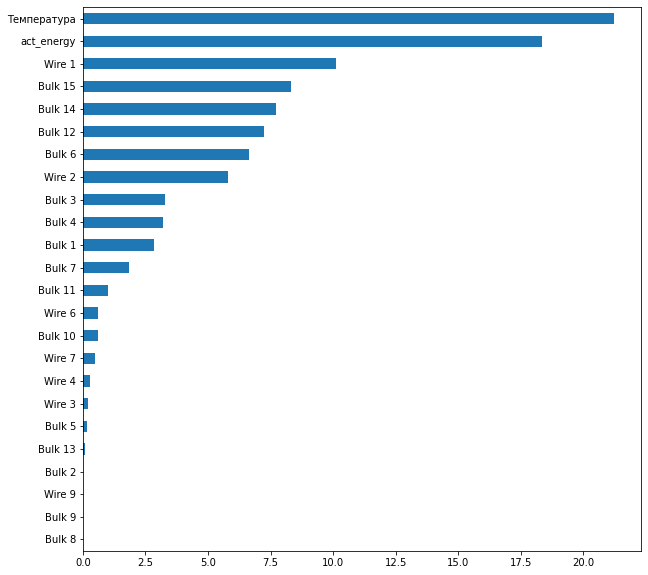

In [68]:
(pd.Series(result_cat.best_estimator_.feature_importances_, index=features.columns).sort_values()
   .plot(kind='barh', figsize=(10,10)))

In [69]:
print('MAE CatBoost', abs(result_cat.best_score_))

MAE CatBoost 6.529588474093368


In [70]:
print('MAE best parameters',result_cat.best_params_)

MAE best parameters {'depth': 10, 'learning_rate': 0.01}


### Полносвязная нейронная сеть

In [ ]:
model_neu = keras.models.Sequential()

model_neu.add(keras.layers.Dense(units=40, input_dim=features_train.shape[1],activation='relu'))
model_neu.add(keras.layers.Dense(units=1,activation='relu'))
model_neu.compile(loss='mean_absolute_error', optimizer='sgd', metrics=['mean_absolute_error'])

model_neu.fit(features_train, target_train, epochs=22, verbose=2,
          validation_data=(scaler.transform(features_test), target_test))

С нейронной сетью я не справилась, результаты плохие получила, больше 16 в лучшем случае.

<b> В итоге, наилучшее значение метрики МАЕ получаем для модели CatBoost</b>

In [52]:
print('На тестовой выборке метрика МАЕ для модели CatBoost равна ', mean_absolute_error(result_cat.predict(scaler.transform(features_test)), target_test))

На тестовой выборке метрика МАЕ для модели CatBoost равна  6.754955072179166


<b>Отчет</b>
```

   В ходе проекта были проанализированы характеристики технологического процеса легирования стали с целью возможного снижения энергопотребления. 
   
  План работы включал в себя: загрузку данных; соотнесение данных с описанием технологического процесса, определение целевой переменной на основе имеющейся информации, уточнение вопросов по имеющимся данным и возможно запрос дополнительных ; далее изучение качества данных, их полноты, выявление внутренних противоречий (если таковые имелись бы) и их устранение, заполнение отсутствующих данных разумными знчениями или удаление таких пропусков как неинформативных; далее этап моделирования: подбор признаков модели и целевой функции, выбор моделей машинного обучения, выбор метрики качества; непосредственно моделирование: обучение различных моделей с подбором гиперпараметров, сравнение качества моделей на обучающей выборке, выбор лучшей модели и потом проверка качества на тестовой выборке; написание отчета.
  
  В целом, все пункты намеченного плана были выполнены. Данные оказались хорошего качества, практически без выбросов, полностью достаточные для понимания и описания технологического процесса. В качестве целевой функции была принята последняя измеренная температура каждого ковша. В ходе проверки и анализа данных были найдены "подозрительные" объкекты, когда при нескольким временам измерений соответствовала только одна температура. Таке данные были отброшены. В целом, были еще варианты, как проверить внутреннюю непротиворечивость даных: монотонность и непересечение времени событий для каждого ковша, количество измерений температуры должно быть на 1 больше, чем количество событий и т.д. Однако такая проверка показала, что при разумной псоледовательности событий для некоторых ковшей времена событий полностью совпадают. Возможно, смеси были насыпаны одновременно, или просто время внесено неверно. Существенного влияния на моделировния такие случаи оказать были не должны, так что было принято решение их оставить. 
  
  В качестве признаков модели изначально я хотела принять все события, расположенные в порядке следования в соответствии с данным временем событий. Однаком здесь возникли сложности в том как расположить все события последовательно при этом заполняя нулями количество поданной смеси/проволоки если таковой не было и установки соответствующей температуры и мощности равными предыдущему значению и нулю соотвественно. Процесс упорядочивания времени был несложным, а вот дальше была идея попробовать и мультиндексы для упорядочивания, и словари, но в любом случае это требовало дополнительного времени. Поэтому в первом приближении в качестве признаков я взяла для каждого ковша: количество поданной смеси каждого вида (если смесь не была подана, то ее количество было положено 0), количество каждой проволоки (аналогично), начальую температуру смеси в ковше, информацию о газе для каждого ковша, а также суммарные активную и реактивную энергии, затраченные на нагревание ковша в течение всего процесса легирования. Такой подход дал неплохие результаты, а предложенный первоначально поход может быть использован в дальнейшем в качестве эксперимента. 
  
  При моделировании лучшие результаты покзала модель градиентного бустинга CatBoost. Параметры модели learning rate=0.01, depth=10, на тестовой выборке качество составило МАЕ 6.7.
  
  Вклад признаков в целевую функцию следующий: основной вклад в итоговую температуру вносят начальная температура и количество поданной энергии, что ожидаемо.Среди подаваемых смесей и проволок наибольший вклад наблюдаем для Wire 1, Wire 2, Bulk 6, Bulk 12, Bulk 14, Bulk 15. 
  
  В качестве улучшения модели хотелось бы попробовать следующее:
  1) учесть динамику процесса. В целом, насколько понимаю, порядок расположения признаков не имеет значения, так что интересно, как можно учесть динамику. Возможно, стоит включать не только сами значения температуры например, но также и разности или вторые разности соседних, чтобы учесть как бы производную изменения температуры. Вообще не знаю пока, как работать с такими временными рядами на входе.
  2) возможно, промежуточные температуры включать в качестве тагретов и предсказывать их и как-то так итерационно добраться до предсказания итоговой температуры. В этом случае, в том числе, действительно можно попытаться управлять энергосбережением, поскольку  предсказывая каждую температуру на каждой итерации мы можем хотя бы brute force  перебором вариатов в модели подобрать такой процесс, который дает минмальные затраты энергии на нагревание при условии фиксироавнной итоговой температуры.
  2') отсюда следует предложение 'инверсного' моделирования:) попробовть так подобрать параметры, чтобы минимизировать сумму затраченной энергии на нагревание. Это совсем другая задача получается 😕
  3) весь курс я слышу/думаю, что между признаками может существовать некоторая связь. которую кстаи частично коллинеаностью проверяем (но коэффициент корреляции не всегда видит связь), и если эта связь есть. то как ее использоать. например. если на диаграмме рассеяния мы увидим что признаки обрауют полумесяц наприер, как это можно включить в модель?
  4) возможно, имеет смысл рассмотреть не только количество поданных смесей, но также какие-то ключевые элементы состава исходного сырья и подаваемых смесей, потому что количество веществ может помочь в предсказании температуры. По сути, температура на каждой итерации за исключением полностью должна определяться составом и температурой исходного сырья.
  
  В целом, проект был интересным, данные хорошие, понятные и с ними приятно работать, есть над чем подумать. 
  
``` 